**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [ ]:
%cd /content
!rm -rf Pytorch-Image-Classification
!git clone https://github.com/Dreaming-future/Pytorch-Image-Classification.git
%cd Pytorch-Image-Classification/
!pip install -r requirements.txt
%cd CIFAR10_code/

/content
Cloning into 'Pytorch-Image-Classification'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 279 (delta 22), reused 31 (delta 11), pack-reused 228
Receiving objects: 100% (279/279), 842.12 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/Pytorch-Image-Classification
/content/Pytorch-Image-Classification/CIFAR10_code


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [ ]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [ ]:
Batch_Size = 128

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [ ]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [ ]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

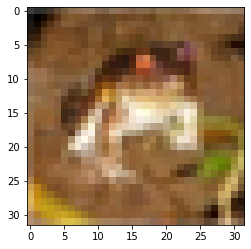

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

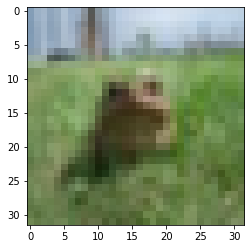

In [ ]:
imshow(im[0])

In [ ]:
im[0].shape

torch.Size([3, 32, 32])

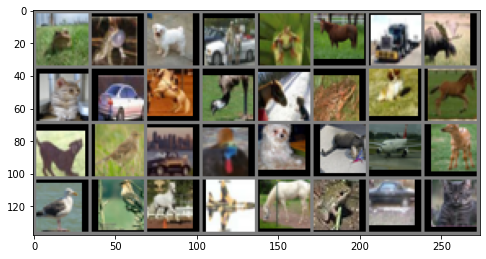

In [ ]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（MobileNet v1）

在之前的文章中讲的AlexNet、VGG、GoogLeNet以及ResNet网络，它们都是传统卷积神经网络（都是使用的传统卷积层），缺点在于内存需求大、运算量大导致无法在移动设备以及嵌入式设备上运行。而本文要讲的MobileNet网络就是专门为**移动端，嵌入式端**而设计。

### MobileNet v1

MobileNet网络是由google团队在2017年提出的，专注于移动端或者嵌入式设备中的轻量级CNN网络。相比传统卷积神经网络，在准确率小幅降低的前提下大大减少模型参数与运算量。(相比VGG16准确率减少了0.9%，但模型参数只有VGG的1/32)。

要说MobileNet网络的优点，无疑是其中的**Depthwise Convolution结构**(大大减少运算量和参数数量)。下图展示了传统卷积与DW卷积的差异，在传统卷积中，每个卷积核的channel与输入特征矩阵的channel相等（每个卷积核都会与输入特征矩阵的每一个维度进行卷积运算）。而在DW卷积中，每个卷积核的channel都是等于1的（每个卷积核只负责输入特征矩阵的一个channel，故卷积核的个数必须等于输入特征矩阵的channel数，从而使得输出特征矩阵的channel数也等于输入特征矩阵的channel数）

<img src="https://img-blog.csdnimg.cn/20200426162556656.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


刚刚说了使用DW卷积后输出特征矩阵的channel是与输入特征矩阵的channel相等的，如果想改变/自定义输出特征矩阵的channel，那只需要在DW卷积后接上一个PW卷积即可，如下图所示，其实PW卷积就是普通的卷积而已（只不过卷积核大小为1）。通常DW卷积和PW卷积是放在一起使用的，一起叫做**Depthwise Separable Convolution（深度可分卷积）**。


<img src="https://img-blog.csdnimg.cn/20200426163946303.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


那Depthwise Separable Convolution（深度可分卷积）与传统的卷积相比有到底能节省多少计算量呢，下图对比了这两个卷积方式的计算量，其中Df是输入特征矩阵的宽高（这里假设宽和高相等），Dk是卷积核的大小，M是输入特征矩阵的channel，N是输出特征矩阵的channel，卷积计算量近似等于卷积核的高 x 卷积核的宽 x 卷积核的channel x 输入特征矩阵的高 x 输入特征矩阵的宽（这里假设stride等于1），在我们mobilenet网络中DW卷积都是是使用3x3大小的卷积核。所以理论上普通卷积计算量是DW+PW卷积的8到9倍（公式来源于原论文）：


<img src="https://img-blog.csdnimg.cn/20200426164254206.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


在了解完Depthwise Separable Convolution（深度可分卷积）后在看下mobilenet v1的网络结构，左侧的表格是mobileNetv1的网络结构，表中标Conv的表示普通卷积，Conv dw代表刚刚说的DW卷积，s表示步距，根据表格信息就能很容易的搭建出mobileNet v1网络。在mobilenetv1原论文中，还提出了两个超参数，一个是α一个是β。α参数是一个倍率因子，用来调整卷积核的个数，β是控制输入网络的图像尺寸参数，下图右侧给出了使用不同α和β网络的分类准确率，计算量以及模型参数：

<img src="https://img-blog.csdnimg.cn/20200426165207571.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


#### 判断是否使用GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self,in_channels,out_channels,stride=1):
        super(Block,self).__init__()
        # groups参数就是深度可分离卷积的关键
        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=stride,
                               padding=1,groups=in_channels,bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
    def forward(self,x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        return x
        
# 深度可分离卷积 DepthWise Separable Convolution
class MobileNetV1(nn.Module):
    # (128,2) means conv channel=128, conv stride=2, by default conv stride=1
    cfg = [64,(128,2),128,(256,2),256,(512,2),512,512,512,512,512,(1024,2),1024]
    
    def __init__(self, num_classes=10,alpha=1.0,beta=1.0):
        super(MobileNetV1,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.avg = nn.AvgPool2d(kernel_size=2)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(1024,num_classes)
    
    def _make_layers(self, in_channels):
        layers = []
        for x in self.cfg:
            out_channels = x if isinstance(x,int) else x[0]
            stride = 1 if isinstance(x,int) else x[1]
            layers.append(Block(in_channels,out_channels,stride))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.avg(x)
        x = x.view(x.size()[0],-1)
        x = self.linear(x)
        return x

In [ ]:
net = MobileNetV1(num_classes=10).to(device)

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 30, 30]             288
       BatchNorm2d-5           [-1, 32, 30, 30]              64
              ReLU-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 30, 30]           2,048
       BatchNorm2d-8           [-1, 64, 30, 30]             128
              ReLU-9           [-1, 64, 30, 30]               0
            Block-10           [-1, 64, 30, 30]               0
           Conv2d-11           [-1, 64, 15, 15]             576
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
           Conv2d-14          [-1, 128,

In [ ]:
print(net)

MobileNetV1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 128, kernel_

In [ ]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


In [ ]:
net = MobileNetV1(num_classes=10).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

### 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [ ]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(net.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

### 6. 训练

In [ ]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/MoblieNetV1.pth'

文件已存在


In [ ]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:0.475179  Train Acc:84.05% Test Loss:0.450865  Test Acc:84.63%  Learning Rate:0.001000	Time 00:42
Epoch [  2/ 20]  Train Loss:0.402703  Train Acc:86.11% Test Loss:0.435882  Test Acc:85.43%  Learning Rate:0.001000	Time 00:41
Epoch [  3/ 20]  Train Loss:0.372723  Train Acc:87.41% Test Loss:0.421508  Test Acc:85.82%  Learning Rate:0.001000	Time 00:42
Epoch [  4/ 20]  Train Loss:0.346282  Train Acc:88.12% Test Loss:0.419511  Test Acc:86.02%  Learning Rate:0.001000	Time 00:42
Epoch [  5/ 20]  Train Loss:0.324420  Train Acc:88.89% Test Loss:0.413064  Test Acc:86.27%  Learning Rate:0.001000	Time 00:42
Epoch [  6/ 20]  Train Loss:0.314476  Train Acc:89.28% Test Loss:0.376176  Test Acc:87.08%  Learning Rate:0.001000	Time 00:42
Epoch [  7/ 20]  Train Loss:0.299415  Train Acc:89.77% Test Loss:0.395033  Test Acc:86.57%  Learning Rate:0.001000	Time 00:42
Epoch [  8/ 20]  Train Loss:0.286484  Train Acc:90.10% Test Loss:0.386857  Test Acc:87.36%  Learning Rate:0.001000	Tim

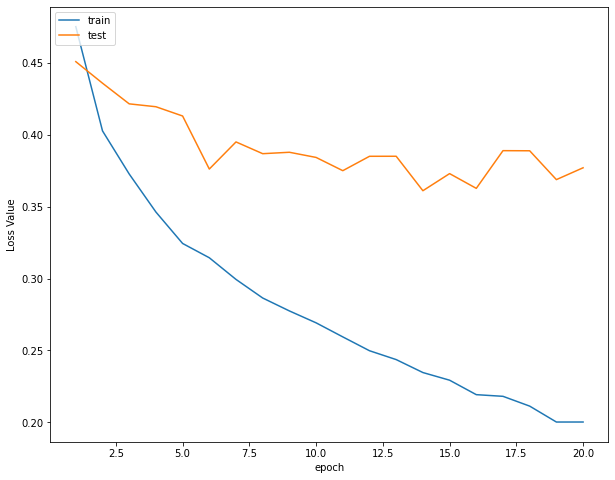

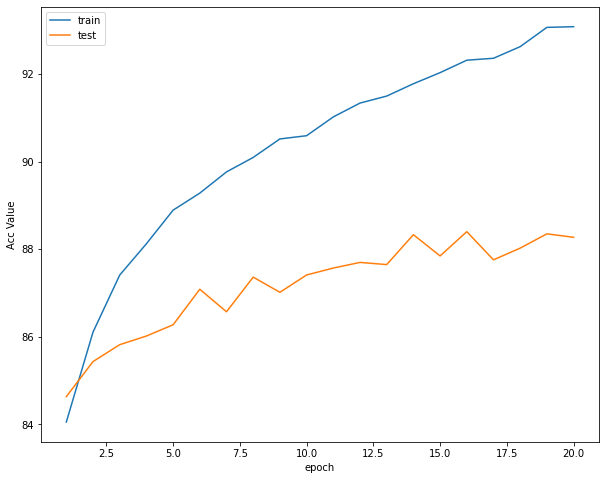

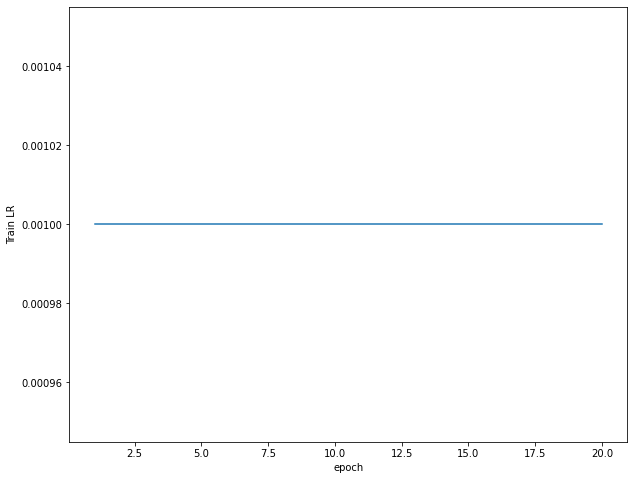

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

### 7.测试

In [ ]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 88.70 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86.30 %
Accuracy of   car : 95.20 %
Accuracy of  bird : 84.20 %
Accuracy of   cat : 80.40 %
Accuracy of  deer : 88.50 %
Accuracy of   dog : 80.30 %
Accuracy of  frog : 92.80 %
Accuracy of horse : 91.80 %
Accuracy of  ship : 91.60 %
Accuracy of truck : 93.20 %


Accuracy Rate = 88.28125%


<Figure size 1800x288 with 0 Axes>

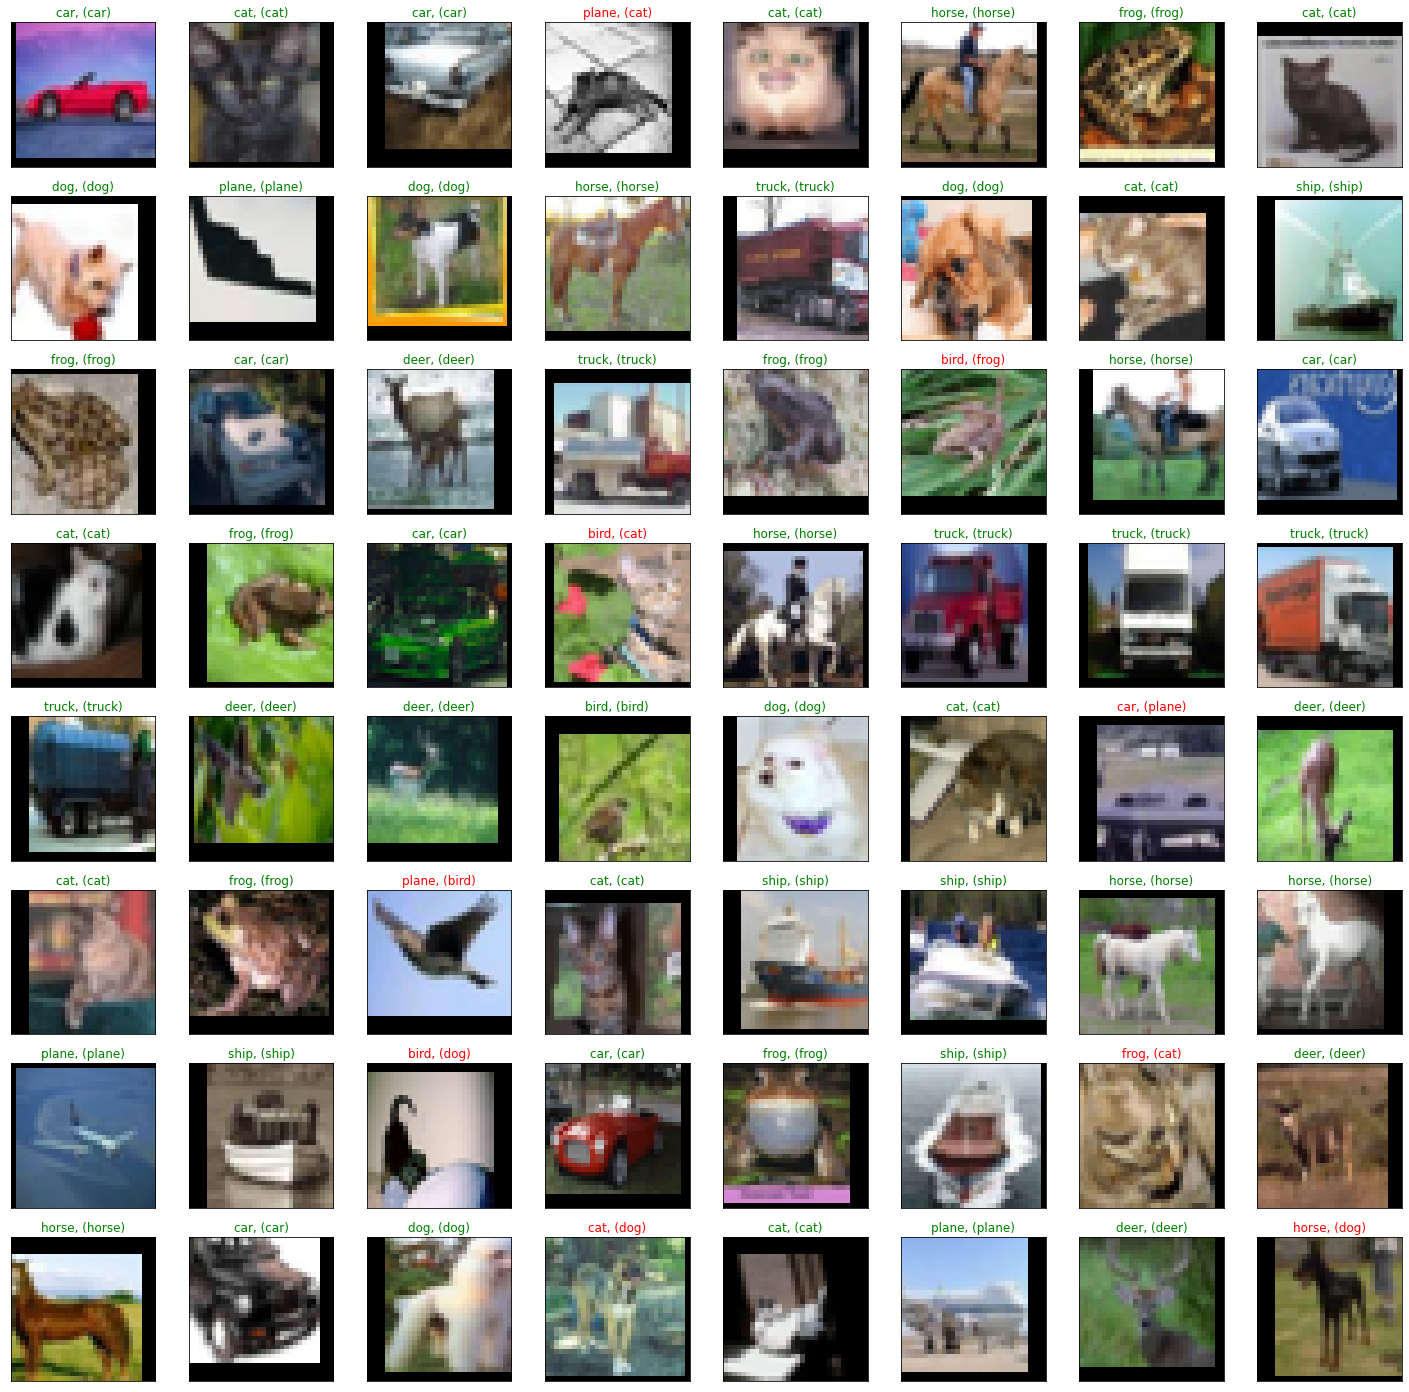

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

In [ ]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')

### 9. 预测

In [ ]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV1(num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

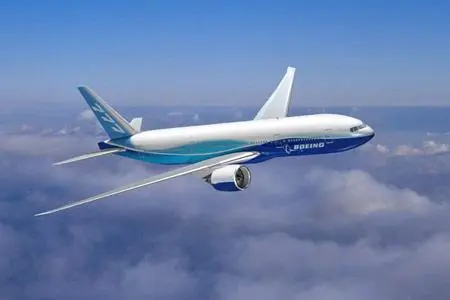

In [ ]:
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.9943e-01, 6.7068e-06, 3.0023e-04, 1.4798e-07, 8.2353e-07, 7.8057e-08,
         5.0757e-07, 1.9969e-08, 2.5490e-04, 3.7836e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([9.4358], device='cuda:0')
分类 plane


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


<Response [200]>


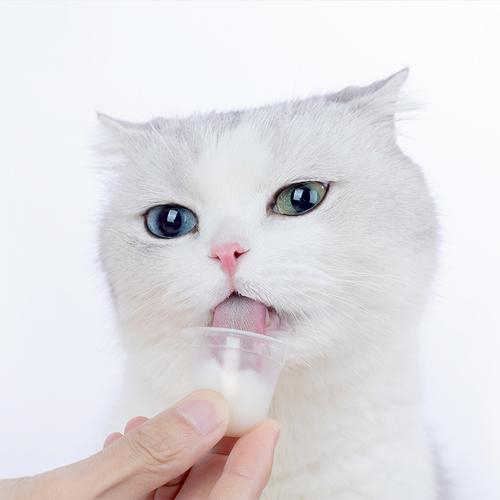

In [ ]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[3.1054e-02, 1.1702e-06, 4.5120e-02, 5.3701e-01, 1.1922e-02, 3.7249e-01,
         2.2320e-03, 6.8314e-05, 1.0060e-04, 8.2913e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 3
tensor([3.5731], device='cuda:0')
分类 cat


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
